# ML Coding Challenge NN Notebook - Group: Strangers
> Ning Natalie Lee, Wan Ting Lee, Don Kok Jun Tan, Martin Klapper

***Notebook Acknowledgement:***

> *Linear NN:* Jasmine & Natalie

> *CNN:* Don Tan Kok Jun


# Importing of Libraries

In [2]:
# Importing of all the necessary libraries
import os
import numpy as np
import pandas as pd

from torch.utils import data
import torch, torchvision
from torch import nn, optim

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions and Classes

In [0]:
# implement the ANN network architecture
class ANN(nn.Module):
    
    # define the class constructor
    def __init__(self):

        self.name = "ANN"
        
        # call super class constructor
        super(ANN, self).__init__()
        
        # specify fully-connected (fc) layer 1 - in 28*28, out 300
        self.linear1 = nn.Linear(28*28, 300, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity 
        
        # specify fc layer 2 - in 300, out 130
        self.linear2 = nn.Linear(300, 130, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # specify fc layer 3 - in 130, out 50
        self.linear3 = nn.Linear(130, 50) # the linearity W*x+b
        self.relu3 = nn.ReLU(inplace=True) # the non-linarity

        # specify fc layer 4 - in 50, out 10
        self.linear4 = nn.Linear(50, 10) # the linearity W*x+b
        
        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):
        
        # reshape image pixels
        x = images.view(-1, 28*28)
        
        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))

        # define fc layer 3 forward pass
        x = self.relu3(self.linear3(x))
        
        # define layer 5 forward pass
        x = self.logsoftmax(self.linear4(x))
        
        # return forward pass result
        return x

    def get_name(self):
      return self.name

In [0]:
# implement the CNN network architecture
class CNN(nn.Module):
    
    # define the class constructor
    def __init__(self):
        
        self.name = "CNN"

        # call super class constructor
        super(CNN, self).__init__()
        
        # Convolutional Layer 1, Input shape 28 x 28 x 1, Output shape 14 x 14 x 64
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2)
        )

        # Convolutional Layer 2, Input shape 14 x 14 x 64, Output shape 7 x 7 x 64
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2)
        )

        # Convolutional Layer 3, Input shape 7 x7 x 64, Output shape 7 x 7 x 128
        self.convlayer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Convolutional Layer 4, Input shape 7 x 7 x 128, Output shape 3 x 3 x 128
        self.convlayer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Flatten()
        )

        # Fully-connected (fc) Layer 1, Input shape 1152, Output shape 256
        self.linear1 = nn.Linear(3*3*128, 256, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU() # the non-linearity 
        self.dropout1 = nn.Dropout2d(p=0.2)

        # Fully-connected (fc) Layer 2, Input shape 256, Output shape 256
        self.linear2 = nn.Linear(256, 256, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU() # the non-linearity 
        self.dropout2 = nn.Dropout2d(p=0.2)

        # Fully-connected (fc) Layer 3, Input shape 256, Output shape 128
        self.linear3 = nn.Linear(256, 128, bias=True) # the linearity W*x+b
        self.relu3 = nn.ReLU() # the non-linearity 
        self.dropout3 = nn.Dropout2d(p=0.2)
        
        # Fully-connected (fc) Layer 4, Input shape 128, Output shape 32
        self.linear4 = nn.Linear(128, 32, bias=True) # the linearity W*x+b
        self.relu4 = nn.ReLU() # the non-linearity

        # Fully-connected (fc) Layer 5, Input shape 32, Output shape 10
        self.linear5 = nn.Linear(32, 10, bias=True) # the linearity W*x+b
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):
        
        # reshape image pixels
        x = images.view(-1, 1, 28, 28)

        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        
        x = self.dropout1(self.relu1(self.linear1(x)))
        x = self.dropout2(self.relu2(self.linear2(x)))
        x = self.dropout3(self.relu3(self.linear3(x)))
        x = self.relu4(self.linear4(x))
        x = self.logsoftmax(self.linear5(x))
  
        return x

    def get_name(self):
      return self.name

In [0]:
# Download data and convert it into numpy arrays
def init_data(mini_batch_size):

  if not os.path.exists('./data'): os.makedirs('./data')  # create data directory

  train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
  eval_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)

  # Flattening of the data from 28*28 to 784
  train_images = train_dataset.data.numpy().reshape(-1,28*28)
  train_labels = train_dataset.targets.data.numpy()

  eval_images = eval_dataset.data.numpy().reshape(-1,28*28)
  eval_labels = eval_dataset.targets.data.numpy()

  # Converting numpy array into tensors for NN training
  tensor_train_dataset = data.TensorDataset(torch.Tensor(train_images), torch.Tensor(train_labels))
  train_dataloader = data.DataLoader(tensor_train_dataset, batch_size=mini_batch_size, shuffle=True)

  tensor_eval_dataset = data.TensorDataset(torch.Tensor(eval_images), torch.Tensor(eval_labels))
  eval_dataloader = data.DataLoader(tensor_eval_dataset, batch_size=mini_batch_size, shuffle=True)

  return train_dataloader, eval_dataloader, tensor_train_dataset, tensor_eval_dataset

In [0]:
# Initializing GPU and seed value
def init_gpu_np_seed(seed_value, use_gpu):

  np.random.seed(seed_value)

  torch.manual_seed(seed_value)
  torch.cuda.manual_seed(seed_value)

In [0]:
# Initiatlize model
def init_model(model_type, use_gpu):

  if model_type == "CNN":
    
    model = CNN()

  elif model_type == "ANN":

    model = ANN()
  
  print("")
  print("##################################################################")
  print("################## Neural Network Architecture ###################")
  print("##################################################################")
  print("")

  # print the initialized architectures
  print('Loaded {} architecture:\n\n{}\n'.format(model.get_name(), model))

  # init the number of model parameters
  num_params = 0

  # iterate over the distinct parameters
  for param in model.parameters():

      # collect number of parameters
      num_params += param.numel()

  print("")
  print("##################################################################")
  print("################# Number of Parameters in Model ##################")
  print("##################################################################")
  print("")

  # print the number of model paramters
  print('Number of parameters in {} model: {}.'.format(model.get_name(),num_params))
  
  print("")
  print("##################################################################")
  print("")

  if use_gpu:

    model = model.cuda()

  return model

In [0]:
# Initialize Loss Function
def init_loss_fn(fn_type, use_gpu):
  
  loss_fn = ""
  
  if fn_type == "CE":
    
    loss_fn = nn.CrossEntropyLoss()

  elif fn_type == "NLL":
    
    loss_fn = nn.NLLLoss()

  if use_gpu:
    
    loss_fn = loss_fn.cuda()

  return loss_fn

In [0]:
# Initialize Optimizer
def init_optim(model, optim_type, learning_rate, decay_rate=0):

  optimizer = ""

  if optim_type == "Adam":

    optimizer = optim.Adam(params=model.parameters() , amsgrad=True, lr=learning_rate)

  elif optim_type == "SGD_mom":

    optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9)
  
  elif optim_type == "SGD":

    optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, weight_decay = decay_rate)

  return optimizer


In [0]:
# Train model and return best epoch
def train_model(model, train_dataloader, loss_fn, optimizer, use_gpu):

  if not os.path.exists('./models'): os.makedirs('./models')  # create trained models directory

  # init collection of training epoch losses
  train_epoch_losses = []

  # List to keep track of best epoch
  best_epoch = [-1,1]

  # set the model in training mode
  model.train()

  # train the MNISTNet model
  for epoch in range(num_epochs):
      
      # init collection of mini-batch losses
      train_mini_batch_losses = []
      
      # iterate over all-mini batches
      for i, (images, labels) in enumerate(train_dataloader):
          
          # case: gpu computing enabled
          if use_gpu == True:

            # convert images and labels to cuda tensor
            images = images.cuda()
            labels = labels.cuda()
          
          # run forward pass through the network
          output = model(images)
          
          # reset graph gradients
          model.zero_grad()

          # determine classification loss
          loss = loss_fn(output, labels.long())
          
          # run backward pass
          loss.backward()
          
          # update network paramaters
          optimizer.step()
          
          # collect mini-batch reconstruction loss
          train_mini_batch_losses.append(loss.data.item())
      
      # determine mean min-batch loss of epoch
      train_epoch_loss = np.mean(train_mini_batch_losses)

      if train_epoch_loss < best_epoch[1]:
        best_epoch = [epoch,train_epoch_loss]

      if epoch % 10 == 0:

        print('epoch: {} train-loss: {}'.format( str(epoch), str(train_epoch_loss)))
      
      # # save model to local directory
      model_name = '{}_epoch_{}.pth'.format(model.get_name(),str(epoch))
      torch.save(model.state_dict(), os.path.join("./models", model_name))
      
      # determine mean min-batch loss of epoch
      train_epoch_losses.append(train_epoch_loss)

  return best_epoch

In [0]:
# Loads best epoch and run test
def test_model(model_type, eval_dataloader, eval_dataset, loss_fn, best_epoch):

  model = init_model(model_type, False)

  best_epoch_file = '{}_epoch_{}.pth'.format(str(model.get_name()),str(best_epoch[0]))

  model.load_state_dict(torch.load(os.path.join("./models", best_epoch_file), map_location='cpu'))

  print("Epoch {} for {} model has been loaded".format(best_epoch[0],model.get_name()))

  # init collection of mini-batch losses
  eval_mini_batch_losses = []

  # iterate over all-mini batches
  for i, (images, labels) in enumerate(eval_dataloader):

      # run forward pass through the network
      output = model(images)

      # determine classification loss
      loss = loss_fn(output, labels.long())

      # collect mini-batch reconstruction loss
      eval_mini_batch_losses.append(loss.data.item())

  # determine mean min-batch loss of epoch
  eval_loss = np.mean(eval_mini_batch_losses)

  # print epoch loss
  print('Eval-loss for {} model: {}'.format(model.get_name(),str(eval_loss)))

  accuracy_summary(model, eval_dataset.tensors)


In [0]:
# Print results of test
def accuracy_summary(model, eval_dataset):
  
  print("")
  print("##################################################################")
  print("########################## Test results ##########################")
  print("##################################################################")
  print("")

  predictions = torch.argmax(model(eval_dataset[0].float()), dim=1)
  print("Accuracy achieved :",metrics.accuracy_score(eval_dataset[1], predictions.detach()) * 100, "%")

  print("")
  print("##################################################################")
  print("####################### Confusion matrix #########################")
  print("##################################################################")
  print("")

  # determine classification matrix of the predicted and target classes
  mat = confusion_matrix(eval_dataset[1], predictions.detach())

  # plot corresponding confusion matrix
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=range(0,10), yticklabels=range(0,10))
  plt.title('MNIST classification matrix')
  plt.xlabel('[true label]')
  plt.ylabel('[predicted label]');

  print("")
  print("##################################################################")
  print("")

# 1. ANN Model

## 1a. ANN Model Preperation

### ANN Parameters

In [0]:
# ANN Parameters
num_epochs = 170 #After testing, the best model is epoch 168. Hence, there is no need to run more than 160 epochs.
mini_batch_size = 32 # A small batch size of 32 is chosen as smaller batch sizes are noisy, offering a regularizing effect and lower generalization error. It also makes it easier to fit one batch worth of training data in memory (i.e. when using a GPU).
learning_rate = 0.001 #After testing several learning rates, we found that a learning rate of 0.001 generates the smoothest curve for NLL. A very small learning rate of 0.001 would be preferred, as a large learning rate would rapidly result in a learning rate that is too small for the model to learn effectively.
decay_rate = 0.01 #After testing several decay rates, we found that a decay rate of 0.01 generates the highest accuracy. 
loss_fn_type = "NLL" #After testing several loss functions (Hinge, cross entropy etc), NLL generates the highest accuracy. 
model_type = "ANN" 
optim_type = "SGD" #We chose SGD as SGD is a variant of gradient descent. Instead of performing computations on the whole dataset, which is redundant and inefficient. SGD only computes on a small subset or random selection of data examples. SGD also produces the same performance as regular gradient descent when the learning rate is low.
use_gpu = True
seed_value = 1234

### Training ANN

In [15]:
train_dataloader, eval_dataloader, train_dataset, eval_dataset = init_data(mini_batch_size)

init_gpu_np_seed( seed_value , use_gpu )

model = init_model( model_type ,use_gpu )
optimizer = init_optim( model , optim_type , learning_rate , decay_rate)
loss_fn = init_loss_fn( loss_fn_type , use_gpu )

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.



##################################################################
################## Neural Network Architecture ###################
##################################################################

Loaded ANN architecture:

ANN(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=300, out_features=130, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=130, out_features=50, bias=True)
  (relu3): ReLU(inplace=True)
  (linear4): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)


##################################################################
################# Number of Parameters in Model ##################
##################################################################

Number of parameters in ANN model: 281690.

##################################################################



In [16]:
best_epoch = train_model(model, train_dataloader, loss_fn, optimizer, use_gpu)

epoch: 0 train-loss: 0.560764851140976
epoch: 10 train-loss: 0.26650025940338773
epoch: 20 train-loss: 0.2174763049562772
epoch: 30 train-loss: 0.18820308831532795
epoch: 40 train-loss: 0.1683666286110878
epoch: 50 train-loss: 0.1507545357267062
epoch: 60 train-loss: 0.1371032235701879
epoch: 70 train-loss: 0.12849864881038667
epoch: 80 train-loss: 0.11979375547965368
epoch: 90 train-loss: 0.11277713547150293
epoch: 100 train-loss: 0.10698136672973632
epoch: 110 train-loss: 0.10153287886778514
epoch: 120 train-loss: 0.09980181553761164
epoch: 130 train-loss: 0.09377738041083018
epoch: 140 train-loss: 0.0920221182068189
epoch: 150 train-loss: 0.089039066807429
epoch: 160 train-loss: 0.08542766857147217


## 1b. ANN Model results


##################################################################
################## Neural Network Architecture ###################
##################################################################

Loaded ANN architecture:

ANN(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=300, out_features=130, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=130, out_features=50, bias=True)
  (relu3): ReLU(inplace=True)
  (linear4): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)


##################################################################
################# Number of Parameters in Model ##################
##################################################################

Number of parameters in ANN model: 281690.

##################################################################

Epoch 168 for ANN model has been loaded
Eval-loss for ANN model: 0.3

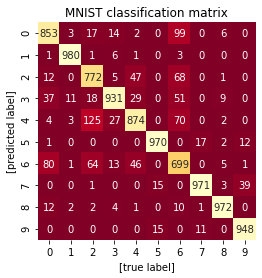

In [17]:
test_model(model_type, eval_dataloader, eval_dataset, loss_fn, best_epoch)

# 2. CNN Model

## 2a. CNN Model Preperation

### CNN Parameters

In [0]:
# Configure CNN Parameters here

num_epochs = 250
mini_batch_size = 32
learning_rate = 0.0001
loss_fn_type = "CE"
model_type = "CNN"
optim_type = "Adam"
use_gpu = True
seed_value = 1234

### Training CNN

In [0]:
train_dataloader, eval_dataloader, train_dataset, eval_dataset = init_data(mini_batch_size)

init_gpu_np_seed( seed_value , use_gpu )

model = init_model( model_type ,use_gpu )
optimizer = init_optim( model , optim_type , learning_rate)
loss_fn = init_loss_fn( loss_fn_type , use_gpu )

##################################################################
################## Neural Network Architecture ###################
##################################################################
Loaded CNN architecture:

CNN(
  (convlayer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (convlayer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten()
  )
  (

In [0]:
best_epoch = train_model(model, train_dataloader, loss_fn, optimizer, use_gpu)

epoch: 0 train-loss: 0.6498786354939143
epoch: 10 train-loss: 0.14304969979344556
epoch: 20 train-loss: 0.0545466991571011
epoch: 30 train-loss: 0.026992548203901
epoch: 40 train-loss: 0.012836790270622199
epoch: 50 train-loss: 0.00855177101032682
epoch: 60 train-loss: 0.005778157129625217
epoch: 70 train-loss: 0.004526942544280496
epoch: 80 train-loss: 0.004071717356351483
epoch: 90 train-loss: 0.004156769692986287
epoch: 100 train-loss: 0.0023916175091369847
epoch: 110 train-loss: 0.004437158266338286
epoch: 120 train-loss: 0.0015029023176760304
epoch: 130 train-loss: 0.0017216056145272357
epoch: 140 train-loss: 0.0012889465524907042
epoch: 150 train-loss: 0.0020196461849193614
epoch: 160 train-loss: 0.0017042482591713953
epoch: 170 train-loss: 0.0025746551714102557
epoch: 180 train-loss: 0.0018920845985284686
epoch: 190 train-loss: 0.0001623954214649744
epoch: 200 train-loss: 0.0023549674040882944
epoch: 210 train-loss: 0.00270130588276838
epoch: 220 train-loss: 0.000576164977685479

## 2b. CNN Model Results

##################################################################
################## Neural Network Architecture ###################
##################################################################
Loaded CNN architecture:

CNN(
  (convlayer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (convlayer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten()
  )
  (

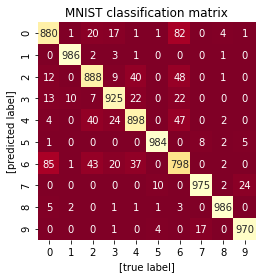

In [0]:
test_model(model_type, eval_dataloader, eval_dataset, loss_fn, best_epoch)